In [1]:
import os
from pprint import pprint

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    make_scorer,
    roc_curve,
    auc,
    recall_score,
)

import seaborn as sns
import matplotlib.pyplot as plt
import optuna
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from eli5.sklearn import PermutationImportance
import shap

/home/elicer/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-08-15 08:48:49.012483: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-15 08:48:49.053546: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-15 08:48:51.881736: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find Tenso

In [2]:
f1_scorer = make_scorer(f1_score, pos_label=1, average = 'binary')

In [3]:
def get_clf_eval(y_test, y_pred=None):
    confusion = confusion_matrix(y_test, y_pred, labels=[True, False])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=[True, False])
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, labels=[True, False])

    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))

In [4]:
# 데이터 불러오기
train = pd.read_csv('./data/train_0815_variable.csv')
test = pd.read_csv('./data/test_0815_variable.csv')

In [5]:
train.columns

Index(['target', 'inconsistant', 'distance_diff_dam_fill1_stage1',
       'distance_diff_dam_fill2_stage1', 'distance_diff_fill1_fill2_stage1',
       'distance_diff_dam_fill1_stage2', 'distance_diff_dam_fill2_stage2',
       'distance_diff_fill1_fill2_stage2', 'distance_diff_dam_fill1_stage3',
       'distance_diff_dam_fill2_stage3', 'distance_diff_fill1_fill2_stage3',
       'cure_time_dam', 'cure_time_fill2', 'press21_autoclave', 'thon_time',
       'discharged_dist_stage1_dam', 'discharged_dist_stage2_dam',
       'discharged_dist_stage3_dam', 'equip', 'dam_time', 'fill1_time',
       'fill2_time', 'autoclave_time', 'pallet', 'qty', 'chamber_temp',
       'model_suffix', 'select_workorder', 'direction'],
      dtype='object')

In [6]:
train['pallet'] = train['pallet'].astype('int64')
test['pallet'] = test['pallet'].astype('int64')

In [7]:
# 학습시 inconsistant 전부 빼고 적용
train_sel = train[train['inconsistant'] == 0]

In [8]:
# 각 영역별 
dam = ['target', 'distance_diff_dam_fill1_stage1',
       'distance_diff_dam_fill2_stage1', 'distance_diff_fill1_fill2_stage1',
       'cure_time_dam', 'cure_time_fill2', 'thon_time', 'dam_time', 'fill1_time',
       'fill2_time',
       'discharged_dist_stage1_dam',
       'equip', 'pallet', 'select_workorder', 'direction', 
       'model_suffix']

fill1 = [
        'target', 
       'distance_diff_dam_fill1_stage2', 'distance_diff_dam_fill2_stage2',
       'distance_diff_fill1_fill2_stage2', 
       'cure_time_dam', 'cure_time_fill2', 'thon_time', 'dam_time', 'fill1_time',
       'fill2_time',
       'discharged_dist_stage2_dam',
       'equip', 'pallet', 'select_workorder', 'direction', 
       'model_suffix'
        ]

fill2 = [
        'target', 'distance_diff_dam_fill1_stage3',
       'distance_diff_dam_fill2_stage3', 'distance_diff_fill1_fill2_stage3',
       'cure_time_dam', 'cure_time_fill2', 'thon_time', 'dam_time', 'fill1_time',
       'fill2_time',
       'discharged_dist_stage3_dam',
       'equip', 'pallet', 'select_workorder', 'direction', 
       'model_suffix'
]

autoclave = [
        'target',
       'press21_autoclave',
        'equip', 'autoclave_time', 'pallet',
       'chamber_temp', 'model_suffix', 'select_workorder'
            ]

df_dam = train_sel[dam]
df_fill1 = train_sel[fill1]
df_fill2 = train_sel[fill2]
df_autoclave = train_sel[autoclave]

# Stage1

In [9]:
X_dam = df_dam.drop(columns=['target'])
y_dam = df_dam['target']

cat_features_indices_dam = ['pallet', 'model_suffix']

X_train, X_valid, y_train, y_valid = train_test_split(X_dam, y_dam, test_size=0.2, random_state=42)

train_pool = Pool(X_train, y_train, cat_features=cat_features_indices_dam)
valid_pool = Pool(X_valid, y_valid, cat_features=cat_features_indices_dam)

def objective(trial):
    # 하이퍼파라미터를 샘플링
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1.0, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 10.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "random_strength": trial.suggest_float("random_strength", 1e-9, 10.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        "od_wait": trial.suggest_int("od_wait", 10, 50),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "scale_pos_weight": trial.suggest_int('scale_pos_weight', 1, 20),
        'random_state': 42,
        "verbose": 0
    }
    
    # CatBoost 모델 학습
    model = CatBoostClassifier(**params)
    model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=50, verbose=0)
    
    # 검증 세트에 대한 예측 및 평가
    preds = model.predict(X_valid)
    f1 = f1_score(y_valid, preds, average='macro')
    
    return f1

# Optuna 스터디 생성 및 최적화
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# 최적의 하이퍼파라미터 출력
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-08-15 08:48:58,100] A new study created in memory with name: no-name-688f2a40-a1e1-4ada-ad30-51fe686e91d2
[I 2024-08-15 08:49:02,932] Trial 0 finished with value: 0.5603725182694501 and parameters: {'iterations': 215, 'depth': 10, 'learning_rate': 0.0032063580335317046, 'l2_leaf_reg': 6.639470134180494, 'border_count': 95, 'random_strength': 1.8016332761031975, 'bagging_temperature': 0.7554576500415642, 'od_type': 'IncToDec', 'od_wait': 47, 'boosting_type': 'Plain', 'scale_pos_weight': 6}. Best is trial 0 with value: 0.5603725182694501.
[I 2024-08-15 08:49:18,635] Trial 1 finished with value: 0.5012078778947149 and parameters: {'iterations': 506, 'depth': 10, 'learning_rate': 0.008911658532025019, 'l2_leaf_reg': 5.627146401300649, 'border_count': 249, 'random_strength': 3.0984767496796572, 'bagging_temperature': 0.7422638727403578, 'od_type': 'Iter', 'od_wait': 26, 'boosting_type': 'Ordered', 'scale_pos_weight': 3}. Best is trial 0 with value: 0.5603725182694501.
[I 2024-08-15 

Best trial:
  Value: 0.5710527171889865
  Params: 
    iterations: 236
    depth: 5
    learning_rate: 0.22056793230371602
    l2_leaf_reg: 8.864639222463456
    border_count: 111
    random_strength: 1.9822651096330097
    bagging_temperature: 0.7414354556987066
    od_type: Iter
    od_wait: 31
    boosting_type: Plain
    scale_pos_weight: 7


In [10]:
study.best_trial.params

{'iterations': 236,
 'depth': 5,
 'learning_rate': 0.22056793230371602,
 'l2_leaf_reg': 8.864639222463456,
 'border_count': 111,
 'random_strength': 1.9822651096330097,
 'bagging_temperature': 0.7414354556987066,
 'od_type': 'Iter',
 'od_wait': 31,
 'boosting_type': 'Plain',
 'scale_pos_weight': 7}

In [11]:
# 최적의 하이퍼파라미터로 모델 재학습
dam_best_params = study.best_trial.params
dam_best_model = CatBoostClassifier(**dam_best_params)
dam_best_model.fit(X_train, y_train, cat_features=cat_features_indices_dam)

0:	learn: 0.6142182	total: 12.5ms	remaining: 2.93s
1:	learn: 0.5833450	total: 24.5ms	remaining: 2.86s
2:	learn: 0.5594963	total: 36.6ms	remaining: 2.84s
3:	learn: 0.5534312	total: 43.2ms	remaining: 2.5s
4:	learn: 0.5459812	total: 50.7ms	remaining: 2.34s
5:	learn: 0.5409673	total: 62.3ms	remaining: 2.39s
6:	learn: 0.5373307	total: 73.9ms	remaining: 2.42s
7:	learn: 0.5358164	total: 85.7ms	remaining: 2.44s
8:	learn: 0.5342137	total: 97.3ms	remaining: 2.46s
9:	learn: 0.5333038	total: 108ms	remaining: 2.44s
10:	learn: 0.5326740	total: 119ms	remaining: 2.44s
11:	learn: 0.5317313	total: 132ms	remaining: 2.47s
12:	learn: 0.5314881	total: 142ms	remaining: 2.44s
13:	learn: 0.5313999	total: 152ms	remaining: 2.4s
14:	learn: 0.5309147	total: 164ms	remaining: 2.41s
15:	learn: 0.5307274	total: 173ms	remaining: 2.37s
16:	learn: 0.5304594	total: 183ms	remaining: 2.35s
17:	learn: 0.5285068	total: 195ms	remaining: 2.36s
18:	learn: 0.5274729	total: 206ms	remaining: 2.36s
19:	learn: 0.5274729	total: 211ms	

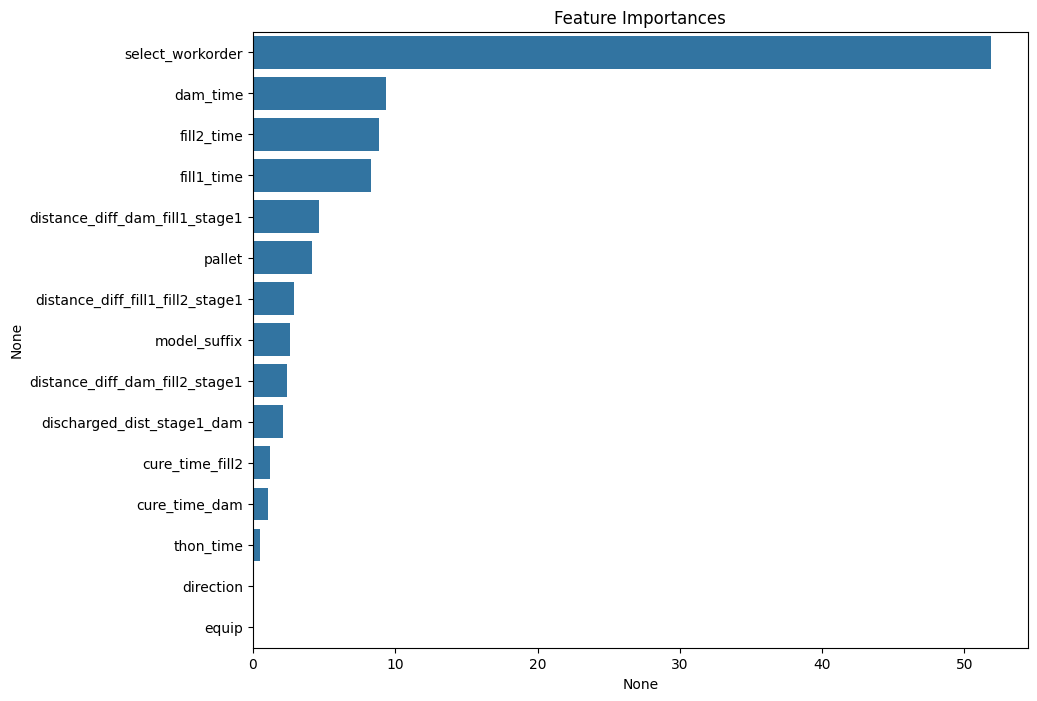

In [12]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(dam_best_model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [13]:
pred = dam_best_model.predict(X_valid)
get_clf_eval(y_valid, pred)

오차행렬:
 [[ 115  365]
 [ 547 7056]]

정확도: 0.8872
정밀도: 0.1737
재현율: 0.2396
F1: 0.2014


# Stage2

In [14]:
X_fill1 = df_fill1.drop(columns=['target'])
y_fill1 = df_fill1['target']

cat_features_indices_fill1 = ['pallet', 'model_suffix']

X_train, X_valid, y_train, y_valid = train_test_split(X_fill1, y_fill1, test_size=0.2, random_state=42)

train_pool = Pool(X_train, y_train, cat_features=cat_features_indices_fill1)
valid_pool = Pool(X_valid, y_valid, cat_features=cat_features_indices_fill1)

def objective(trial):
    # 하이퍼파라미터를 샘플링
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1.0, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 10.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "random_strength": trial.suggest_float("random_strength", 1e-9, 10.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        "od_wait": trial.suggest_int("od_wait", 10, 50),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "scale_pos_weight": trial.suggest_int('scale_pos_weight', 1, 20),
        'random_state': 42,
        "verbose": 0
    }
    
    # CatBoost 모델 학습
    model = CatBoostClassifier(**params)
    model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=50, verbose=0)
    
    # 검증 세트에 대한 예측 및 평가
    preds = model.predict(X_valid)
    f1 = f1_score(y_valid, preds, average='macro')
    
    return f1

# Optuna 스터디 생성 및 최적화
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# 최적의 하이퍼파라미터 출력
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-08-15 08:52:07,865] A new study created in memory with name: no-name-dd41c057-1c25-4003-bcda-3fdae2b78860
[I 2024-08-15 08:52:16,620] Trial 0 finished with value: 0.4935930199994515 and parameters: {'iterations': 922, 'depth': 4, 'learning_rate': 0.01214682602186725, 'l2_leaf_reg': 7.38961490388486, 'border_count': 120, 'random_strength': 3.0495852409593147, 'bagging_temperature': 0.35073353105809757, 'od_type': 'IncToDec', 'od_wait': 27, 'boosting_type': 'Plain', 'scale_pos_weight': 19}. Best is trial 0 with value: 0.4935930199994515.
[I 2024-08-15 08:52:19,406] Trial 1 finished with value: 0.5648860399778747 and parameters: {'iterations': 282, 'depth': 4, 'learning_rate': 0.052505701697501725, 'l2_leaf_reg': 9.69408066042963, 'border_count': 48, 'random_strength': 3.98697454325356, 'bagging_temperature': 0.8427543131583469, 'od_type': 'IncToDec', 'od_wait': 49, 'boosting_type': 'Plain', 'scale_pos_weight': 6}. Best is trial 1 with value: 0.5648860399778747.
[I 2024-08-15 08:5

Best trial:
  Value: 0.5734593268824427
  Params: 
    iterations: 334
    depth: 4
    learning_rate: 0.12463561170069241
    l2_leaf_reg: 9.276322896872744
    border_count: 152
    random_strength: 6.258924205922235
    bagging_temperature: 0.3503360547749178
    od_type: IncToDec
    od_wait: 44
    boosting_type: Plain
    scale_pos_weight: 7


In [15]:
study.best_trial.params

{'iterations': 334,
 'depth': 4,
 'learning_rate': 0.12463561170069241,
 'l2_leaf_reg': 9.276322896872744,
 'border_count': 152,
 'random_strength': 6.258924205922235,
 'bagging_temperature': 0.3503360547749178,
 'od_type': 'IncToDec',
 'od_wait': 44,
 'boosting_type': 'Plain',
 'scale_pos_weight': 7}

In [16]:
# 최적의 하이퍼파라미터로 모델 재학습
fill1_best_params = study.best_trial.params
fill1_best_model = CatBoostClassifier(**fill1_best_params)
fill1_best_model.fit(X_train, y_train, cat_features=cat_features_indices_fill1)

0:	learn: 0.6574382	total: 11.6ms	remaining: 3.86s
1:	learn: 0.6317994	total: 22.5ms	remaining: 3.74s
2:	learn: 0.6182880	total: 33.2ms	remaining: 3.66s
3:	learn: 0.6088553	total: 43.5ms	remaining: 3.59s
4:	learn: 0.5951695	total: 53.4ms	remaining: 3.51s
5:	learn: 0.5847814	total: 64.1ms	remaining: 3.5s
6:	learn: 0.5652876	total: 74.4ms	remaining: 3.48s
7:	learn: 0.5628983	total: 79.9ms	remaining: 3.26s
8:	learn: 0.5610785	total: 85.2ms	remaining: 3.08s
9:	learn: 0.5591425	total: 96ms	remaining: 3.11s
10:	learn: 0.5550107	total: 107ms	remaining: 3.14s
11:	learn: 0.5468704	total: 117ms	remaining: 3.15s
12:	learn: 0.5456270	total: 127ms	remaining: 3.15s
13:	learn: 0.5450085	total: 137ms	remaining: 3.14s
14:	learn: 0.5434207	total: 146ms	remaining: 3.11s
15:	learn: 0.5422752	total: 154ms	remaining: 3.05s
16:	learn: 0.5418995	total: 160ms	remaining: 2.99s
17:	learn: 0.5417806	total: 165ms	remaining: 2.9s
18:	learn: 0.5415386	total: 173ms	remaining: 2.87s
19:	learn: 0.5402237	total: 183ms	r

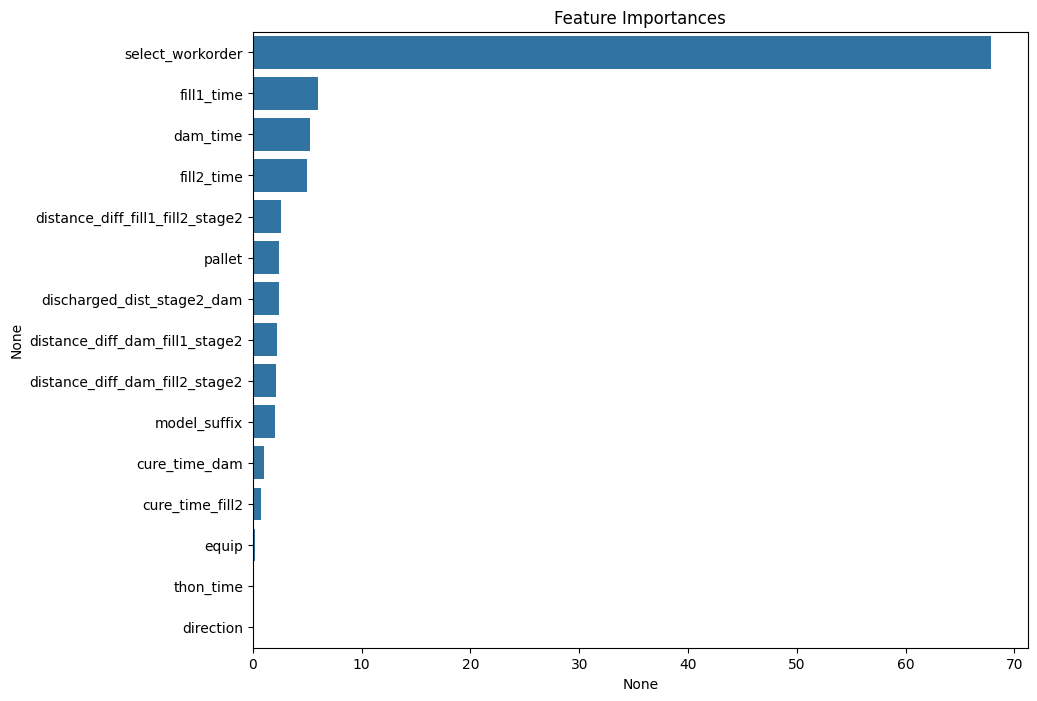

In [17]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(fill1_best_model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [18]:
pred = fill1_best_model.predict(X_valid)
get_clf_eval(y_valid, pred)

오차행렬:
 [[ 138  342]
 [ 685 6918]]

정확도: 0.8729
정밀도: 0.1677
재현율: 0.2875
F1: 0.2118


# Stage3

In [19]:
X_fill2 = df_fill2.drop(columns=['target'])
y_fill2 = df_fill2['target']

cat_features_indices_fill2 = ['pallet', 'model_suffix']

X_train, X_valid, y_train, y_valid = train_test_split(X_fill2, y_fill2, test_size=0.2, random_state=42)

train_pool = Pool(X_train, y_train, cat_features=cat_features_indices_fill2)
valid_pool = Pool(X_valid, y_valid, cat_features=cat_features_indices_fill2)

def objective(trial):
    # 하이퍼파라미터를 샘플링
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1.0, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 10.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "random_strength": trial.suggest_float("random_strength", 1e-9, 10.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        "od_wait": trial.suggest_int("od_wait", 10, 50),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "scale_pos_weight": trial.suggest_int('scale_pos_weight', 1, 20),
        'random_state': 42,
        "verbose": 0
    }
    
    # CatBoost 모델 학습
    model = CatBoostClassifier(**params)
    model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=50, verbose=0)
    
    # 검증 세트에 대한 예측 및 평가
    preds = model.predict(X_valid)
    f1 = f1_score(y_valid, preds, average='macro')
    
    return f1

# Optuna 스터디 생성 및 최적화
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# 최적의 하이퍼파라미터 출력
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-08-15 08:56:04,281] A new study created in memory with name: no-name-fb0ac6fa-6995-4eaa-9a77-9005b8e21df6
[I 2024-08-15 08:56:05,327] Trial 0 finished with value: 0.5275557867102559 and parameters: {'iterations': 576, 'depth': 5, 'learning_rate': 0.31682515815211676, 'l2_leaf_reg': 6.48855711139526, 'border_count': 108, 'random_strength': 1.3256247170167683, 'bagging_temperature': 0.6963057896042236, 'od_type': 'Iter', 'od_wait': 41, 'boosting_type': 'Plain', 'scale_pos_weight': 3}. Best is trial 0 with value: 0.5275557867102559.
[I 2024-08-15 08:56:14,863] Trial 1 finished with value: 0.5082534114485394 and parameters: {'iterations': 621, 'depth': 4, 'learning_rate': 0.009343751323648437, 'l2_leaf_reg': 6.927839021987455, 'border_count': 106, 'random_strength': 2.848468845378612, 'bagging_temperature': 0.9406891340655562, 'od_type': 'IncToDec', 'od_wait': 38, 'boosting_type': 'Ordered', 'scale_pos_weight': 5}. Best is trial 0 with value: 0.5275557867102559.
[I 2024-08-15 08:56

Best trial:
  Value: 0.5778772893115994
  Params: 
    iterations: 478
    depth: 8
    learning_rate: 0.17594070422606475
    l2_leaf_reg: 4.413277220576568
    border_count: 92
    random_strength: 5.197530580014972
    bagging_temperature: 0.3571284007240777
    od_type: Iter
    od_wait: 15
    boosting_type: Plain
    scale_pos_weight: 7


In [20]:
study.best_trial.params

{'iterations': 478,
 'depth': 8,
 'learning_rate': 0.17594070422606475,
 'l2_leaf_reg': 4.413277220576568,
 'border_count': 92,
 'random_strength': 5.197530580014972,
 'bagging_temperature': 0.3571284007240777,
 'od_type': 'Iter',
 'od_wait': 15,
 'boosting_type': 'Plain',
 'scale_pos_weight': 7}

In [21]:
# 최적의 하이퍼파라미터로 모델 재학습
fill2_best_params = study.best_trial.params
fill2_best_model = CatBoostClassifier(**fill2_best_params)
fill2_best_model.fit(X_train, y_train, cat_features=cat_features_indices_fill2)

0:	learn: 0.6442267	total: 19.6ms	remaining: 9.35s
1:	learn: 0.5945620	total: 35.7ms	remaining: 8.49s
2:	learn: 0.5817589	total: 50.3ms	remaining: 7.96s
3:	learn: 0.5727514	total: 65.1ms	remaining: 7.72s
4:	learn: 0.5561836	total: 83ms	remaining: 7.85s
5:	learn: 0.5517797	total: 97.7ms	remaining: 7.69s
6:	learn: 0.5453359	total: 116ms	remaining: 7.81s
7:	learn: 0.5440874	total: 122ms	remaining: 7.14s
8:	learn: 0.5426437	total: 136ms	remaining: 7.1s
9:	learn: 0.5386571	total: 152ms	remaining: 7.1s
10:	learn: 0.5357735	total: 164ms	remaining: 6.97s
11:	learn: 0.5337914	total: 182ms	remaining: 7.07s
12:	learn: 0.5333312	total: 196ms	remaining: 7.01s
13:	learn: 0.5332171	total: 202ms	remaining: 6.68s
14:	learn: 0.5331397	total: 207ms	remaining: 6.4s
15:	learn: 0.5322228	total: 223ms	remaining: 6.44s
16:	learn: 0.5313068	total: 238ms	remaining: 6.46s
17:	learn: 0.5309153	total: 251ms	remaining: 6.41s
18:	learn: 0.5303336	total: 268ms	remaining: 6.48s
19:	learn: 0.5297732	total: 283ms	remain

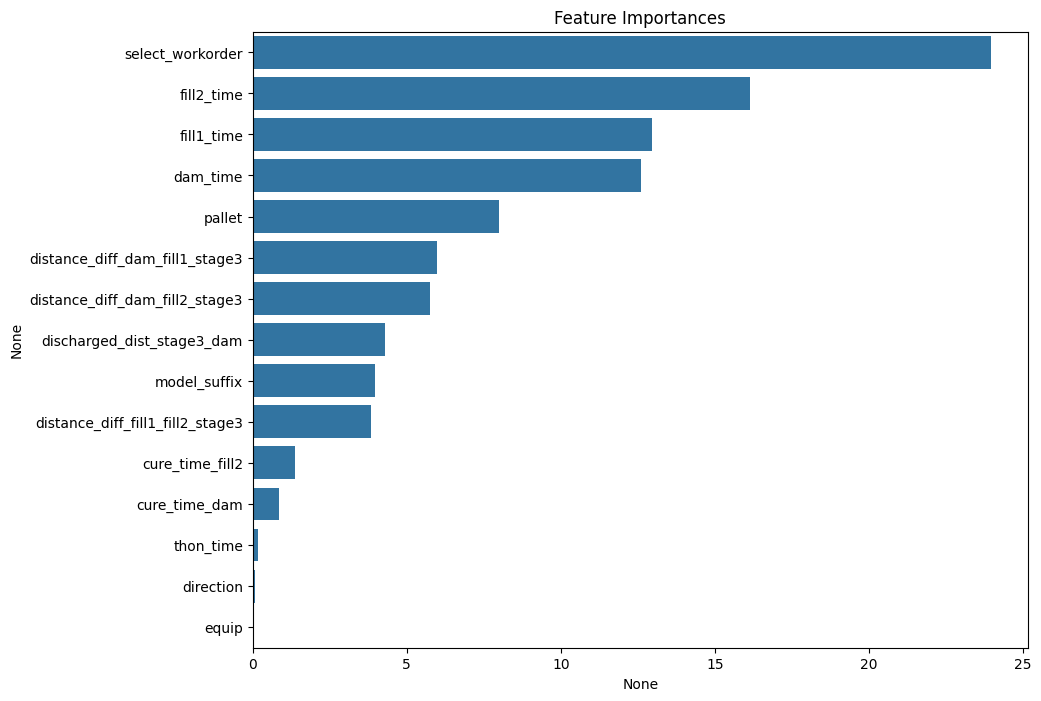

In [22]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(fill2_best_model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [23]:
pred = fill2_best_model.predict(X_valid)
get_clf_eval(y_valid, pred)

오차행렬:
 [[  77  403]
 [ 388 7215]]

정확도: 0.9021
정밀도: 0.1656
재현율: 0.1604
F1: 0.1630


# AutoClave

In [24]:
X_AutoClave = df_autoclave.drop(columns=['target'])
y_AutoClave = df_autoclave['target']

cat_features_indices_autoclave = ['pallet', 'model_suffix', 'chamber_temp']

X_train, X_valid, y_train, y_valid = train_test_split(X_AutoClave, y_AutoClave, test_size=0.2, random_state=42)

train_pool = Pool(X_train, y_train, cat_features=cat_features_indices_autoclave)
valid_pool = Pool(X_valid, y_valid, cat_features=cat_features_indices_autoclave)

def objective(trial):
    # 하이퍼파라미터를 샘플링
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1.0, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 10.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "random_strength": trial.suggest_float("random_strength", 1e-9, 10.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        "od_wait": trial.suggest_int("od_wait", 10, 50),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "scale_pos_weight": trial.suggest_int('scale_pos_weight', 1, 20),
        'random_state': 42,
        "verbose": 0
    }
    
    # CatBoost 모델 학습
    model = CatBoostClassifier(**params)
    model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=50, verbose=0)
    
    # 검증 세트에 대한 예측 및 평가
    preds = model.predict(X_valid)
    f1 = f1_score(y_valid, preds, average='macro')
    
    return f1

# Optuna 스터디 생성 및 최적화
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# 최적의 하이퍼파라미터 출력
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-08-15 08:59:36,803] A new study created in memory with name: no-name-4264a318-537e-4bcd-bb37-ba566d4fab48
[I 2024-08-15 09:00:14,616] Trial 0 finished with value: 0.5622309218270767 and parameters: {'iterations': 942, 'depth': 10, 'learning_rate': 0.03265370519553601, 'l2_leaf_reg': 6.527228194557908, 'border_count': 242, 'random_strength': 9.665485785677129, 'bagging_temperature': 0.7576735862251547, 'od_type': 'Iter', 'od_wait': 45, 'boosting_type': 'Ordered', 'scale_pos_weight': 19}. Best is trial 0 with value: 0.5622309218270767.
[I 2024-08-15 09:00:15,215] Trial 1 finished with value: 0.5246470199243812 and parameters: {'iterations': 170, 'depth': 4, 'learning_rate': 0.2832151320629433, 'l2_leaf_reg': 5.816485916013366, 'border_count': 221, 'random_strength': 7.830718957309694, 'bagging_temperature': 0.8397645043372564, 'od_type': 'Iter', 'od_wait': 31, 'boosting_type': 'Plain', 'scale_pos_weight': 1}. Best is trial 0 with value: 0.5622309218270767.
[I 2024-08-15 09:00:18,

Best trial:
  Value: 0.578867144664336
  Params: 
    iterations: 896
    depth: 5
    learning_rate: 0.19372829282244658
    l2_leaf_reg: 0.4057218864346068
    border_count: 58
    random_strength: 9.337959823593332
    bagging_temperature: 0.11538119155526738
    od_type: Iter
    od_wait: 22
    boosting_type: Ordered
    scale_pos_weight: 7


In [25]:
study.best_trial.params

{'iterations': 896,
 'depth': 5,
 'learning_rate': 0.19372829282244658,
 'l2_leaf_reg': 0.4057218864346068,
 'border_count': 58,
 'random_strength': 9.337959823593332,
 'bagging_temperature': 0.11538119155526738,
 'od_type': 'Iter',
 'od_wait': 22,
 'boosting_type': 'Ordered',
 'scale_pos_weight': 7}

In [26]:
# 최적의 하이퍼파라미터로 모델 재학습
AutoClave_best_params = study.best_trial.params
AutoClave_best_model = CatBoostClassifier(**AutoClave_best_params)
AutoClave_best_model.fit(X_train, y_train, cat_features=cat_features_indices_autoclave)

0:	learn: 0.6429543	total: 12.7ms	remaining: 11.4s
1:	learn: 0.6102184	total: 34.7ms	remaining: 15.5s
2:	learn: 0.5725123	total: 52.9ms	remaining: 15.7s
3:	learn: 0.5664921	total: 64.8ms	remaining: 14.4s
4:	learn: 0.5616286	total: 86.8ms	remaining: 15.5s
5:	learn: 0.5585550	total: 98.4ms	remaining: 14.6s
6:	learn: 0.5518421	total: 110ms	remaining: 13.9s
7:	learn: 0.5468014	total: 131ms	remaining: 14.6s
8:	learn: 0.5449502	total: 150ms	remaining: 14.8s
9:	learn: 0.5445328	total: 164ms	remaining: 14.6s
10:	learn: 0.5421589	total: 182ms	remaining: 14.7s
11:	learn: 0.5419927	total: 192ms	remaining: 14.1s
12:	learn: 0.5418123	total: 211ms	remaining: 14.3s
13:	learn: 0.5416910	total: 229ms	remaining: 14.4s
14:	learn: 0.5405913	total: 248ms	remaining: 14.5s
15:	learn: 0.5391757	total: 262ms	remaining: 14.4s
16:	learn: 0.5391572	total: 272ms	remaining: 14.1s
17:	learn: 0.5388610	total: 291ms	remaining: 14.2s
18:	learn: 0.5387530	total: 308ms	remaining: 14.2s
19:	learn: 0.5383731	total: 329ms	r

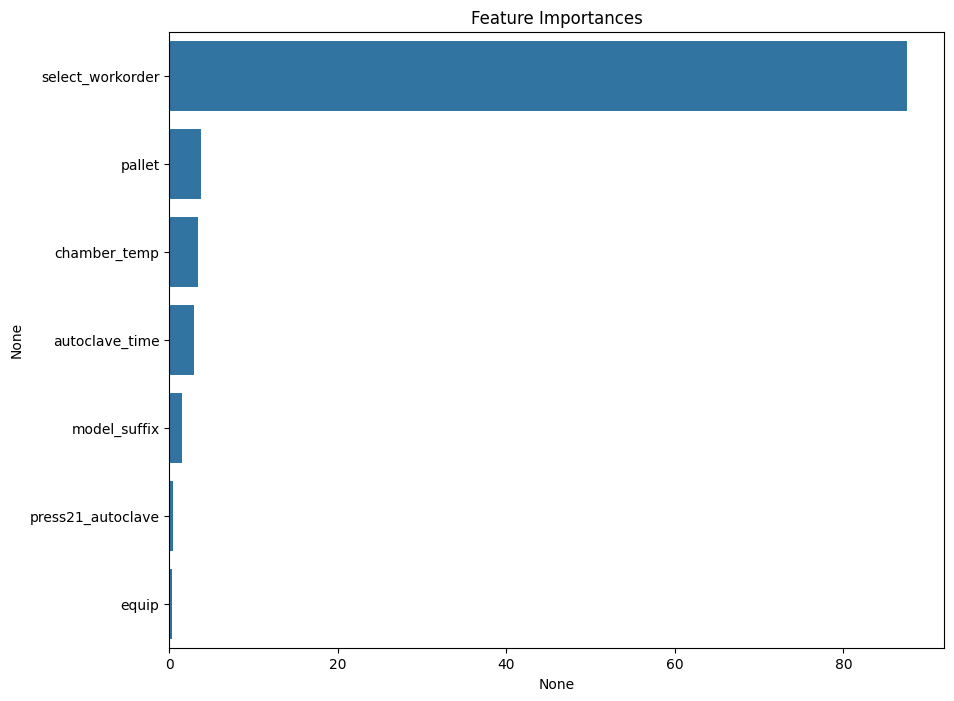

In [27]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(AutoClave_best_model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [28]:
pred = AutoClave_best_model.predict(X_valid)
get_clf_eval(y_valid, pred)

오차행렬:
 [[ 167  313]
 [ 919 6684]]

정확도: 0.8476
정밀도: 0.1538
재현율: 0.3479
F1: 0.2133


# 민감성

In [29]:
# 최적의 하이퍼파라미터로 모델 재학습
dam_best_params = study.best_trial.params
dam_best_model = CatBoostClassifier(**dam_best_params)
dam_best_model.fit(X_dam, y_dam, cat_features=cat_features_indices_dam)

# 최적의 하이퍼파라미터로 모델 재학습
fill1_best_params = study.best_trial.params
fill1_best_model = CatBoostClassifier(**fill1_best_params)
fill1_best_model.fit(X_fill1, y_fill1, cat_features=cat_features_indices_fill1)

# 최적의 하이퍼파라미터로 모델 재학습
fill2_best_params = study.best_trial.params
fill2_best_model = CatBoostClassifier(**fill2_best_params)
fill2_best_model.fit(X_fill2, y_fill2, cat_features=cat_features_indices_fill2)

# 최적의 하이퍼파라미터로 모델 재학습
AutoClave_best_params = study.best_trial.params
AutoClave_best_model = CatBoostClassifier(**AutoClave_best_params)
AutoClave_best_model.fit(X_AutoClave, y_AutoClave, cat_features=cat_features_indices_autoclave)

0:	learn: 0.6571439	total: 19.9ms	remaining: 17.8s
1:	learn: 0.5961256	total: 41.7ms	remaining: 18.6s
2:	learn: 0.5842970	total: 63.4ms	remaining: 18.9s
3:	learn: 0.5761082	total: 83.7ms	remaining: 18.7s
4:	learn: 0.5720861	total: 96.9ms	remaining: 17.3s
5:	learn: 0.5607276	total: 118ms	remaining: 17.5s
6:	learn: 0.5537494	total: 136ms	remaining: 17.2s
7:	learn: 0.5487169	total: 155ms	remaining: 17.2s
8:	learn: 0.5480848	total: 167ms	remaining: 16.4s
9:	learn: 0.5476756	total: 177ms	remaining: 15.7s
10:	learn: 0.5449648	total: 199ms	remaining: 16s
11:	learn: 0.5439744	total: 220ms	remaining: 16.2s
12:	learn: 0.5417001	total: 241ms	remaining: 16.4s
13:	learn: 0.5368295	total: 263ms	remaining: 16.6s
14:	learn: 0.5355928	total: 281ms	remaining: 16.5s
15:	learn: 0.5355867	total: 291ms	remaining: 16s
16:	learn: 0.5354241	total: 306ms	remaining: 15.8s
17:	learn: 0.5350947	total: 327ms	remaining: 15.9s
18:	learn: 0.5350471	total: 339ms	remaining: 15.6s
19:	learn: 0.5349812	total: 352ms	remain

In [30]:
test_dam_x = test[X_dam.columns]
test_fill1_x = test[X_fill1.columns]
test_fill2_x = test[X_fill2.columns]
test_AutoClave_x = test[X_AutoClave.columns]

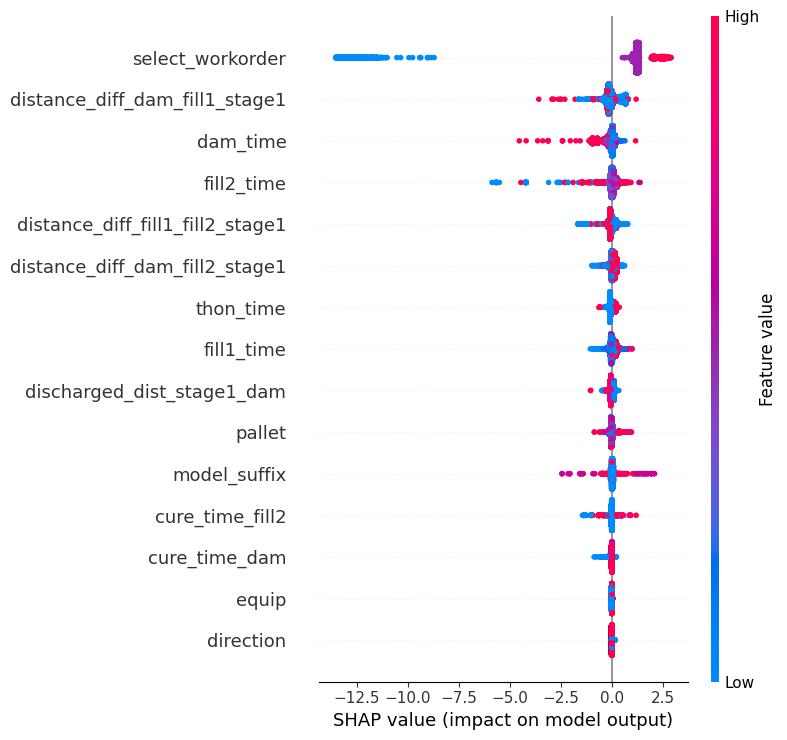

In [31]:
explainer = shap.Explainer(dam_best_model)
shap_values = explainer(test_dam_x)
shap.initjs()

shap.summary_plot(shap_values, test_dam_x)

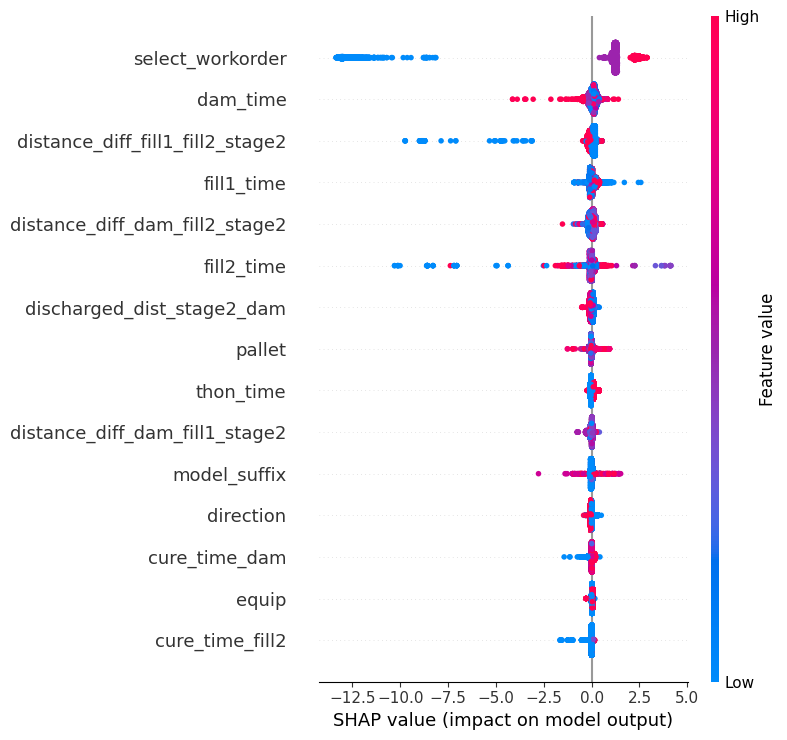

In [32]:
explainer = shap.Explainer(fill1_best_model)
shap_values = explainer(test_fill1_x)
shap.initjs()

shap.summary_plot(shap_values, test_fill1_x)

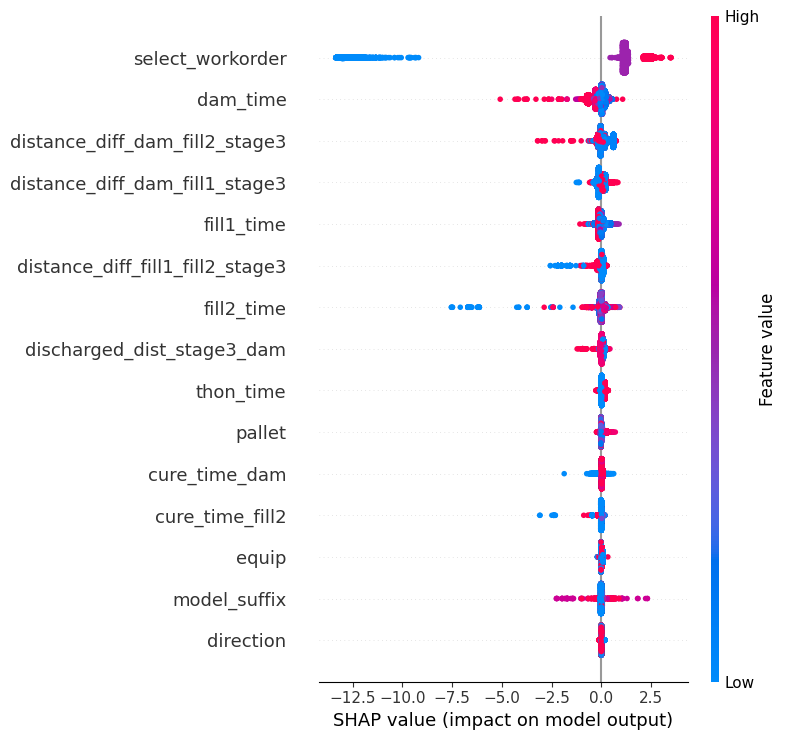

In [33]:
explainer = shap.Explainer(fill2_best_model)
shap_values = explainer(test_fill2_x)
shap.initjs()

shap.summary_plot(shap_values, test_fill2_x)

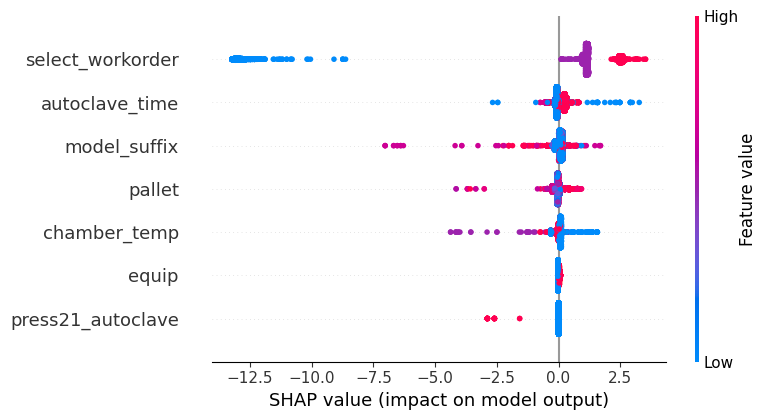

In [34]:
explainer = shap.Explainer(AutoClave_best_model)
shap_values = explainer(test_AutoClave_x)
shap.initjs()

shap.summary_plot(shap_values, test_AutoClave_x)

In [35]:
dam_test_pred = dam_best_model.predict(test_dam_x)
dam_test_pred

array([0, 0, 0, ..., 0, 1, 0])

In [36]:
fill1_test_pred = fill1_best_model.predict(test_fill1_x)
fill1_test_pred

array([0, 0, 0, ..., 0, 0, 0])

In [37]:
fill2_test_pred = fill2_best_model.predict(test_fill2_x)
fill2_test_pred

array([0, 0, 0, ..., 0, 1, 0])

In [38]:
AutoClave_test_pred = AutoClave_best_model.predict(test_AutoClave_x)
AutoClave_test_pred

array([0, 0, 0, ..., 0, 1, 0])

In [39]:
result = np.logical_or(dam_test_pred, fill1_test_pred)
result = np.logical_or(result, fill2_test_pred)
result = np.logical_or(result, AutoClave_test_pred)

In [40]:
y_pred = np.where(result == 1, "AbNormal", "Normal")

In [41]:
np.unique(y_pred, return_counts = True)

(array(['AbNormal', 'Normal'], dtype='<U8'), array([ 2562, 14799]))

In [42]:
test['target'] = y_pred

In [43]:
pd.crosstab(test['inconsistant'], test['target'])

target,AbNormal,Normal
inconsistant,,
0,2550,14783
1,12,16


In [44]:
test['target'] = np.where(test['inconsistant'] == 1, 'AbNormal', test['target'])

In [47]:
pd.crosstab(test['inconsistant'], test['target'])

target,AbNormal,Normal
inconsistant,,
0,2550,14783
1,28,0


In [48]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["target"] = y_pred

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)